# Flow Network Solver

### General imports

In [1]:
# %pylab
# %run FastFlowNets.py 64 1 0
%matplotlib inline

# widen notebook view
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import sys, os
args = sys.argv
sys.executable

import numpy as np
import copy
import itertools
from numpy import zeros as zeros
from numpy import ones as ones
from numpy import array as array
from numpy import arange as arange
from numpy import meshgrid as meshgrid
from numpy import dot as dot
from numpy.linalg import inv as inv

# import cupy as cp

import cProfile
import re
import time

import numpy.linalg as la
import numpy.random as rand
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from datetime import datetime

# My functions
import NETfuncs, Constraints, Matrixfuncs, Statistics, Classes, Big_Class, FileFuncs, DatasetManipulations

In [2]:
## for plots and data save

# figure size
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams.update({'font.size': 14})

# comp_path = "C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\figs and data\\"
comp_path = "C:\\Users\\roiee\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\figs and data\\"

### Roie Larger Network

In [3]:
# User variables

NGrid = 6  # lattice dimension is Ngrid X Ngrid
# NGrid = 7  # for counter, lattice dimension is Ngrid X 1
# NGrid = 3 # lattice dimansion is Ngrid X Ngrid

task_type = 'dual_no_cell'
# task_type = 'Allostery_one_pair'  # 1 pair of input and outputs
# task_type = 'Allostery'  # 2 pairs of input and outputs
# task_type = 'Allostery_contrastive'  # 1 input, 2 outputs, 1 ground
# task_type = 'Regression_contrastive'  # 1 input, 2 outputs, 1 ground
# task_type = 'Flow_clockwise'  # 2 pairs of input and outputs, test is flowing from both inputs to both outputs
# task_type = 'XOR'  # 2 inputs and 2 outputs. difference between output nodes encodes the XOR result of the 2 inputs
# task_type = 'Channeling_diag'  # 1st from input to diagonal output, then from output to 2 perpindicular nodes. 
#                                # test from input to output
# task_type = 'Channeling_straight' # 1st from input to output on same column, then from output to 2 perpindicular nodes. 
#                                   # test from input to output (same as 1st)
# task_type = 'Counter'  # 1 col of cells, task: # marbles in right arm of crosses equals # of drive cycles.
# task_type = 'Memristor'  # 1 col of cells, task: # marbles in right arm of crosses equals # of drive cycles.
# task_type = 'Iris'  # classify 3 irises (outputs) given 4 inputs. Training randomly picks input node values 
#                     # from predetermined dataset and output node to block
# sub_task_type = '2in2out'
sub_task_type = '2in1out'

# flow_scheme='dual'

if task_type == 'dual_no_cell':
    flow_scheme='dual'
    K_scheme='R_propto_deltap'
    net_typ='FC'
    u_thresh_noise_mag = 0.5  # add noise to u threshold above which marbles move - normal dist. noise, amplitude as in here
elif task_type == 'Allostery_contrastive' or task_type=='Regression_contrastive':
    # flow_scheme='taktak'
    # flow_scheme='None'
    flow_scheme='dual'
    # K_scheme='marbles_p_lower_l_half'
    # K_scheme='marbles_p_upper_l_half'
    K_scheme='marbles_pressure'
    u_thresh_noise_mag = 0.5  # add noise to u threshold above which marbles move - normal dist. noise, amplitude as in here
    # net_typ='Nachi'
    net_typ='Cells'
else:
    flow_scheme='None'
    net_typ='Cells'
    
# row = int(np.floor(np.sqrt(NGrid))-1)  # row (and column) of input and output nodes in the NGrid X NGrid cell array
row = 3

## for Iris dataset calssification 
train_frac = 0.8

# for dual_no_cell
Nin=3  # number of input nodes
Nout=2  # number of output nodes

## for Contrastive learning
# etta = 1  # not for dual
# desired_p_frac = array([[0.25, 0.1],[0.1, 0.2]])  # regression 2in2out
# desired_p_frac = array([0.9, 0.1])  # regression 2in1out 
desired_p_frac = array([[0.4, 0.2, 0.1],[0.3, 0.3, 0.3]]).T  # for dual_no_cell has to be a [NinXNout] array
# mag_factor = (NGrid-2*row) * 6  # for Allostery and Regression, no 'taktak'
# mag_factor = (NGrid-2*row) * 5
mag_factor = 24  # for dual problem, an attempt

# Assign input and output nodes a.f.o lattice size and row choice
input_nodes_lst, ground_nodes_lst, output_nodes = Constraints.build_input_output_and_ground(task_type, sub_task_type, row, 
                                                                                            NGrid, Nin=Nin, Nout=Nout)

## These are defaults
# Periodic = False  # flag for lattice periodicity
# net_typ = 'Cells'  # layout for NETfuncs plotNetStructure(). 'Cells' is my style of network and is default
# u_thresh = 1  # threshold to move marbles


# K_type = 'bidir'  # conductivity is the same regardless of flow directions
K_type = 'flow_dep'  # conductivity depends on flow direction - if into cell then maximal, 
                     # if out and there is a marble then lower

# Only for conductivity proportional to current squared scheme    
# beta = 10**(-2)
# beta = 0
# print('beta is:' + str(beta))

K_max = 1
# K_min = np.array([0.0001])  # for counter
# K_min = np.array([0.5])  # real value
K_min = np.array([0.05])  # for Allostery_contrastive
# K_min = np.array([0.1])  # for Regression_contrastive
# K_min = np.array([1/(4*(NGrid-2*row)-1)])  # theoretical marginal for channeling
# K_min = np.logspace(-2.2, -0.0001, num=8, base=10)

# input_p = np.logspace(1.2, 2.2, num=50, base=10)
# input_p = np.array([1])  # for counter
# p_small = 0.1  # for memristor
# p_large = 100  # for memristor
# input_p = np.concatenate((np.linspace(p_small, p_large, 10),  np.linspace(p_large, p_small, 10)))  # for memristor
input_p = np.array([1])  # for Allostery_contrastive

# fixed_node_p = 5*(NGrid-1)/NGrid  # something in the middle
fixed_node_p = 0

noise = 0.0  # noise on initial marble configuration

iterations = 160  # # iterations allowed under flow cycles / updating conductivities

use_gpu = False
solver = Classes.Solver(use_gpu)

## Networkx sizes
scale = 5
squish = 0.01

u_thresh = 1  # p threshold for moving the marbles

alpha=1.5

In [4]:
## Prints

# print('input output node pairs are:\n' + str(input_output_pairs) +'\n')
print('input nodes are:\n' + str(input_nodes_lst) + '\nground nodes are:\n' + str(ground_nodes_lst) +'\n' + 
     '\noutput nodes are:\n' + str(output_nodes))

print('\npressure is:')
for i in input_p:
    print(i)
    
print('\nK min is:')
for i in K_min:
    print(i)

input nodes are:
[0 1 2]
ground nodes are:
[5]

output nodes are:
[3 4]

pressure is:
1

K min is:
0.05


In [6]:
## Variables class - mostly user choices

Variabs = Classes.User_variables(NGrid, input_p, task_type, K_type, iterations, input_nodes_lst, ground_nodes_lst, 
                                 Nin=Nin, Nout=Nout, net_typ=net_typ, u_thresh=u_thresh, u_thresh_noise_mag=u_thresh_noise_mag, 
                                 output_nodes=output_nodes, K_max=K_max, K_min=K_min, K_scheme=K_scheme, train_frac=train_frac, 
                                 desired_p_frac=desired_p_frac, mag_factor=mag_factor, alpha=alpha, sub_task_type=sub_task_type,
                                 flow_scheme=flow_scheme)

if task_type == 'Counter':
    Variabs.assign_fixed_node_p(fixed_node_p)  # assign 0 pressure at counter outputs

creating dataset using specific function


In [7]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class.Big_Class(Variabs)

# CPU or GPU usage
BigClass.assign_solver(solver)

In [8]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Classes.Net_structure()
Strctr.build_incidence(Variabs)
if Variabs.task_type == 'Memristor' or Variabs.task_type == 'Allostery_contrastive' or Variabs.task_type == 'Regression_contrastive':
    Variabs.update_u_thresh(Strctr)
BigClass.add_Strctr(Strctr)  # add to big class
# Identify edges at connections of cells and at boundaries for ease of use
Strctr.Boundaries_and_connections(BigClass)

Periodic False
EI [0 0 1 1 2 2 0 1 2 3 4]
EJ [3 4 3 4 3 4 5 5 5 5 5]
NE 11


In [9]:
## Initiate internal flow network state class

State = Classes.Net_state(use_gpu)
BigClass.add_State(State)  # add to big class

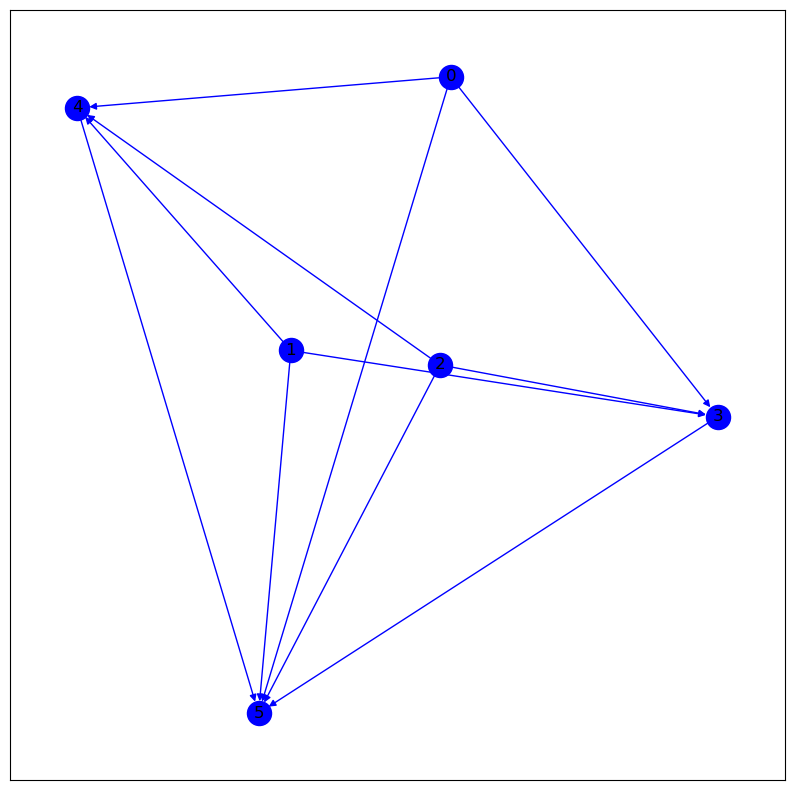

NET is ready


In [10]:
## build network graphics class and plot structure

NET = Classes.Networkx_net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot='yes')
# pos_lattice = NETfuncs.plotNetStructure(NET.NET, plot='yes', node_labels=False)  # position lattice, datatype of networkx
# position lat. dtype=networkx
# pos_lattice = NETfuncs.plotNetStructure(NET.NET, layout='oneCol', plot='no', node_labels=True)
# print(NET.pos_lattice)
BigClass.add_NET(NET)  # add to big class

In [16]:
def flow_iterate_for_profiler():
    # State.flow_iterate(BigClass, sim_type='w marbles', plot='yes', savefig='no') 
    State.flow_iterate(BigClass, sim_type='no marbles', plot='yes', savefig='no') 

### Main part - loop over both cond and pressure

started main loop
p= 1
cycle # 0
train_sample  [0.93333333 0.46666667 0.06666667]  train_target  [0.47333333 0.44      ]

i= 0 
m= 0
NodeData [0.93333333 0.46666667 0.06666667]
Nodes [0 1 2]
EdgeData [0]
Edges []
GroundNodes [5]
statistics after run #0


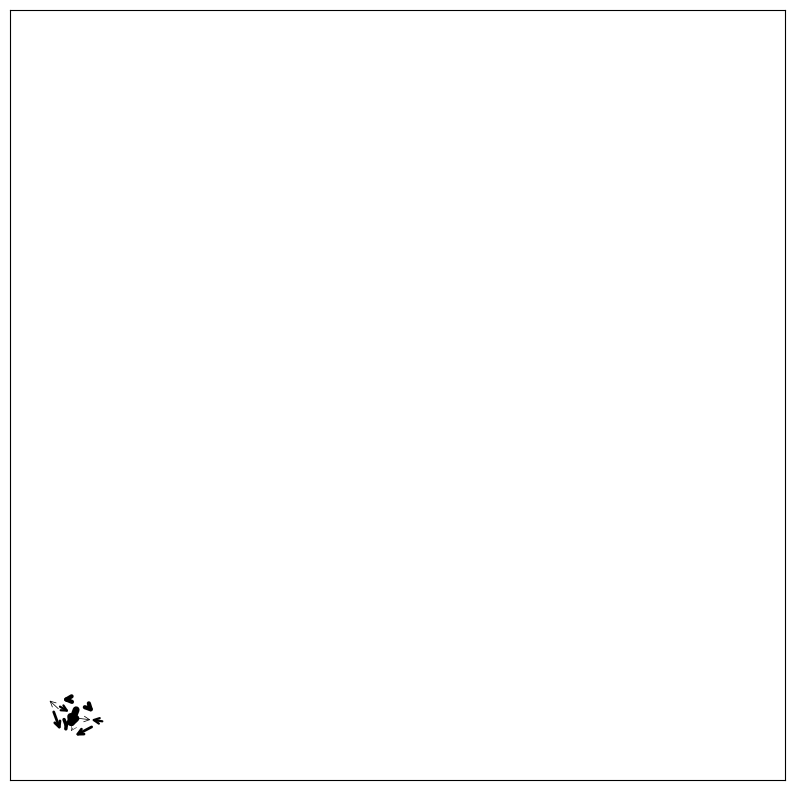

cycle # 0
train_sample  [0.93333333 0.46666667 0.06666667]  train_target  [0.47333333 0.44      ]
OutputNodeData_full_nudged [0.5 0.5]

i= 1 
m= 1
NodeData [24. 24. 24. 12. 12.]
Nodes [0 1 2 3 4]
EdgeData [0]
Edges []
GroundNodes [5]
statistics after run #1


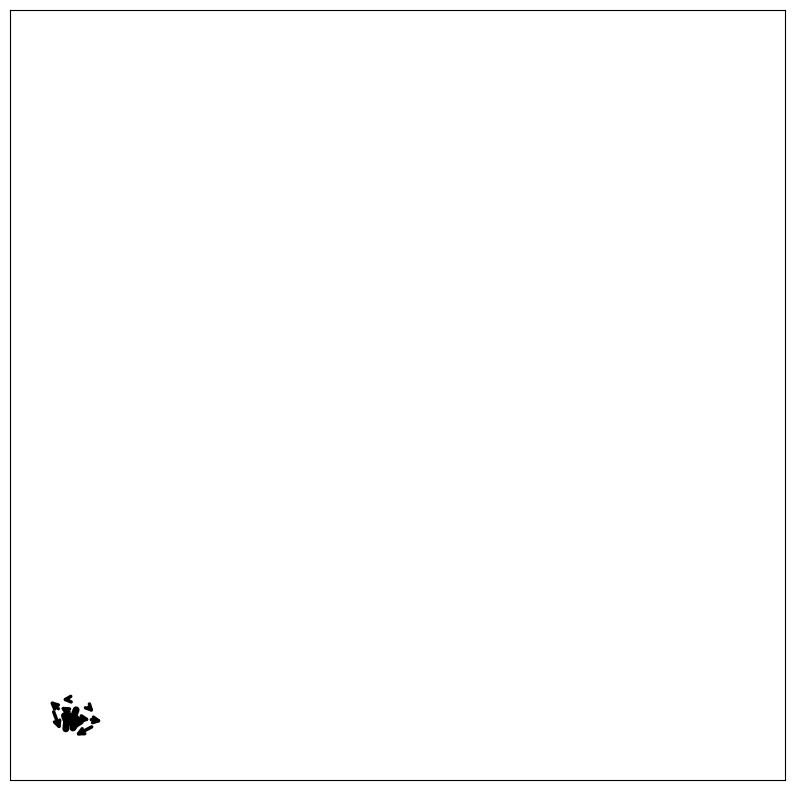

p= 1
total time for simulation 0.450372
100.0% done


In [18]:
# flow MSE and conductivity Hamming a.f.o input pressure

# Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
MSE_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
Hamming_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
power_dissip_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
convergence_time_vec = np.zeros([len(K_min), len(input_p) ])
shear_vec = np.zeros([len(K_min), len(input_p)])  # 
u_allostery_arr = np.zeros([2, 2, len(K_min), len(input_p)])  # 

print('started main loop')
for i, K_min_i in enumerate(K_min):
    
    # K min into Variabs Class 
    Variabs.assign_K_min(K_min_i)
    
    for j, p in enumerate(input_p):
        
        print('p=', p)
        
        start = time.time()  # time start of calculation for profiling

        # input pressure into Variabs Class
        Variabs.assign_input_p(p)

        # Set up constraints for whole loop
        Strctr.Setup_constraints(BigClass)
        
#         print(Strctr.GroundNodes_full)
#         print(Strctr.EdgesTotal)
#         print(Strctr.Edges_full)

        # Initiate K matrix again, not mandatory, better not doing it actually
        State.initiateK(BigClass, noise='no', noise_amp=noise)
        

        # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
        #        change constraints and repeat
        flow_iterate_for_profiler()
        # State.flow_iterate(BigClass, sim_type='w marbles', plot='yes', savefig='no')
        # State.flow_iterate(Variabs, Strctr, NET, sim_type='w marbles', plot='yes', savefig='yes')
        
        # print(State.K)

        MSE_arr[:, i, j] = State.MSE
        Hamming_arr[:, i, j] = State.Hamming
        # print(State.power_dissip)
        power_dissip_arr[:, i, j] = State.power_dissip
        convergence_time_vec[i, j] = State.convergence_time
        
#         State.flow_iterate(BigClass, sim_type='allostery test', plot='yes', savefig='no')  # flow from both inputs
#                                                                                            # to both outputs
        
#         p_mat = Statistics.p_mat(State.p, BigClass.Variabs.NGrid)
        
        # FileFuncs.save_csv_files_Net(BigClass, p, K_min_i, comp_path)
      
        u_allostery_arr[:,:, i, j] = State.u_final
        print('p=', p)
        # print('u=', State.u_final)
#         shear_vec[i, j] = Statistics.shear_type(State.u_final)
#         print('shear is: ' + str(shear_vec[i]))

        end = time.time()  # time end of calculation for profiling
        dt = end-start  # total time it took to run calculation
        print('total time for simulation %f' %dt)
    
    print(str((i+1)*100/len(K_min)) + '% done')
        
convergence_time_vec[np.isnan(convergence_time_vec)] = Variabs.iterations

In [14]:
print('outputs_dual_vec', State.outputs_dual_vec)
print('outputs_dual', State.outputs_dual)
print('p_dual_vec', State.p_dual_vec)
print('p_nudge', State.p_nudge)
print('outputs_vec', State.outputs_vec)
print('p_outputs', State.p_outputs)
if task_type=='Regression_contrastive':
    print('p_desired', Variabs.train_target[0])
print('mag_factor', Variabs.mag_factor)

outputs_dual_vec [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
outputs_dual [0.5 0.5]
p_dual_vec [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]


AttributeError: 'Net_state' object has no attribute 'p_outputs'

In [ ]:
print('error ', State.error_vec, 'error improvement ', (State.error_vec[0]-State.error_vec[1])/State.error_vec[0]*100, '%')
plt.plot(np.abs(State.error_vec))
if BigClass.Variabs.task_type=='Allostery_contrastive':
    plt.plot(np.sum(np.abs(State.error_vec), 1))
elif BigClass.Variabs.task_type=='Regression_contrastive':
    pass
plt.xlabel('iteration #')
plt.ylabel('MSE')
plt.show()

In [ ]:
plt.plot(State.ratio_vec)
# plt.plot(desired_p_frac[0,1]/desired_p_frac[0,0]*np.ones(len(State.ratio_vec)))
# plt.ylim([-1,1.02])
plt.xlabel('iteration #')
plt.ylabel('ratio')
plt.show()

In [ ]:
## Moving averaged ratio vec

# Program to calculate moving average
window_size = 6
 
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
 
# Loop through the array to consider
# every window of size 3
while i < len(State.ratio_vec) - window_size + 1:
   
    # Store elements from i to i+window_size
    # in list to get the current window
    window = State.ratio_vec[i : i + window_size]
 
    # Calculate the average of current window
    window_average = round(sum(window) / window_size, 2)
     
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
     
    # Shift window to right by one position
    i += 1
    
plt.plot(moving_averages)
plt.title(f'moving averaged ratio window={window_size}')
plt.ylim([0,1.3])
plt.xlabel('sample number')
plt.ylabel('ratio')

In [ ]:
plt.plot(np.abs(State.u_final_vec))
# plt.plot(desired_p_frac[0,1]/desired_p_frac[0,0]*np.ones(len(State.ratio_vec)))
# plt.ylim([0,1.02])
plt.xlabel('iteration #')
plt.ylabel('flow at output')
plt.legend(['top right', 'bottom left'])
plt.show()

In [ ]:
# # Save inportant data as CSV

# # import pandas as pd 

# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # df1 = pd.DataFrame(u_allostery_arr)
# # print('C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery' + str(datenow) + '.csv')
# # df1.to_csv("C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery" + str(datenow) + ".csv")
# # df2 = pd.DataFrame(w_vec)
# # df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_w_vec.csv")
# df2 = pd.DataFrame(shear_vec, columns=[str(i) for i in input_p], index=[str(i) for i in K_min])
# df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_shear_vec.csv")

In [ ]:
# df2 = pd.DataFrame(w_vec, columns=[str(i) for i in input_p], index=[str(i) for i in K_min])
# df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_w_vec.csv")

In [ ]:
# ## Figures

# # prelims for figures
# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # fig 1 - MSE, Hamming and Power dissip. afo p

# fig1, axes1 = plt.subplots(nrows=3)
# # axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
# # cmap = plt.get_cmap('cool')
# cmap = sns.cubehelix_palette(as_cmap=True)
# colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[0,:]))]
# legend_every = 10

# for i, color in enumerate(colors, start=0):
#     if i % legend_every == 0:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='K ratio='+str(K_min[i]))
#     else:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color)
#     axes1[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color)
#     axes1[2].plot(range(len(MSE_arr[:,0])), power_dissip_arr[:,i]/input_p[0], color=color)
# axes1[0].legend()
# # plt.show()
# axes1[2].set_xlabel('iteration #')
# axes1[0].set_ylabel('flow MSE')
# axes1[1].set_ylabel('Hamming dist.')
# axes1[2].set_ylabel('power')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'distance_and_P_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig 2 - # cycles until convergence and tau p

# fig2, axes2 = plt.subplots(nrows=2, figsize=(10,6))
# axes2[0].semilogx(K_min, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# axes2[0].set_ylabel('# cycles')
# # axes2[1].plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # axes2[1].set_xlabel('input $p$')
# # axes2[1].set_ylabel('$\\theta$')
# axes2[1].semilogx(K_min, shear_vec, '.', ms=20, mfc='white', label='$\\tau$')
# axes2[1].semilogx(K_min, np.zeros([len(K_min),]))
# axes2[1].set_xlabel('$\\frac{K_{min}}{K_{max}}$')
# axes2[1].set_ylabel('$\\tau$')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'numCycles_and_tau_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')